In [1]:
import os

import time

import numpy as np

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.cm as cm

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 20  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 28  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 28  # Font size of titlea

plt.rcParams['legend.fontsize'] = 20


2025-12-29 09:24:34.186062: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-29 09:24:34.214209: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-29 09:24:34.214240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-29 09:24:34.214279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-29 09:24:34.219920: I tensorflow/core/platform/cpu_feature_g

In [2]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

# HMC

In [3]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([0.2], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+1.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([-0.5], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32))}

2025-12-29 09:24:39.980175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 09:24:40.143218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 09:24:40.143267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 09:24:40.145878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-29 09:24:40.145918: I tensorflow/compile

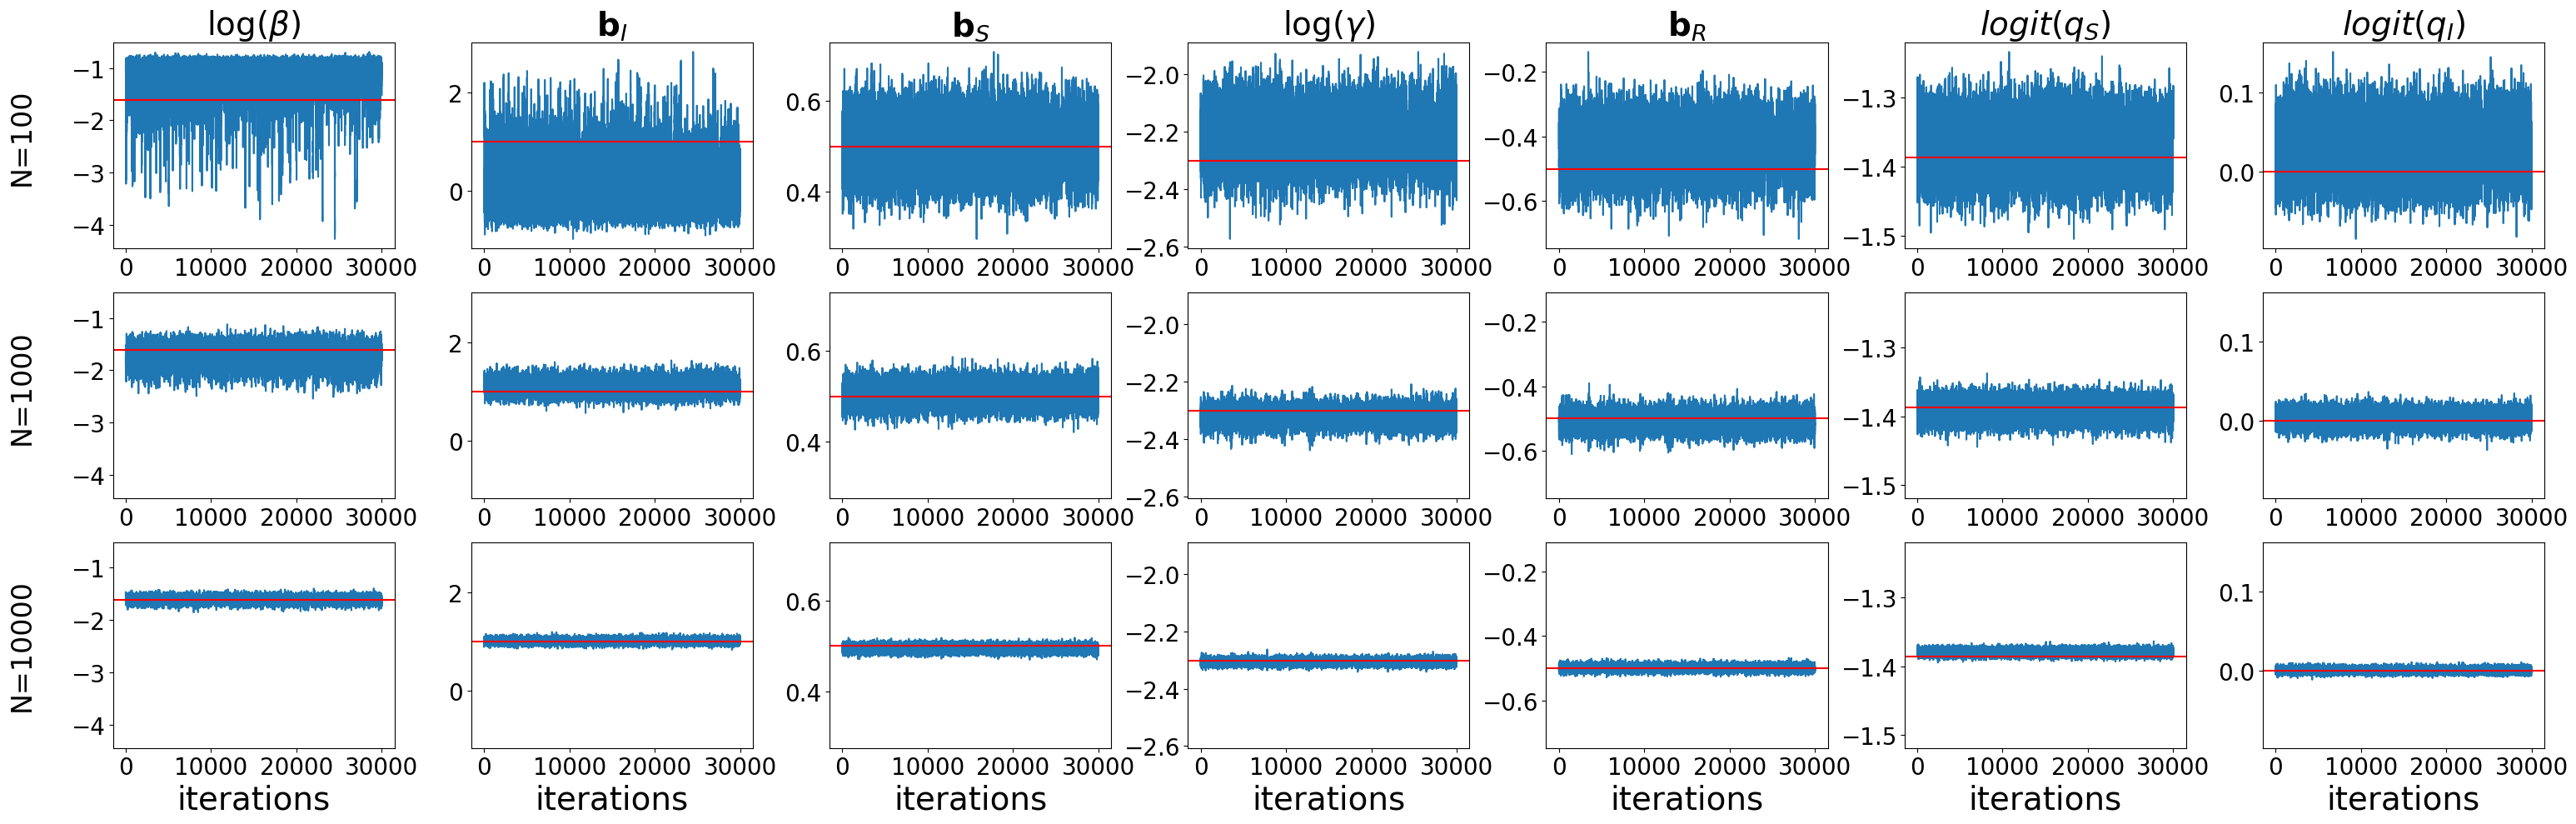

In [4]:
parameters_vector_HMC_true = tf.convert_to_tensor([np.log(0.2), 1.0, 0.5, np.log(0.1), -0.5, logit(0.2), logit(0.5)], dtype = tf.float32)

names_list =  [r"$\log(\beta)$", r"$\mathbf{b}_I$", r"$\mathbf{b}_S$", r"$\log(\gamma)$", r"$\mathbf{b}_R$",
	       r"$logit(q_S)$", r"$logit(q_I)$"]
 
fig, ax = plt.subplots(3, 7, figsize = (30, 10), sharey="col")

counter = 0
for  size in [100, 1000, 10000]:

	posterior_samples = np.load("Data/HMC/Output/"+str(size)+"/HMC_inference_"+str(size)+"_posterior.npy")

	for k in range(7):

		quantiles = np.quantile(posterior_samples[:,k], [0.025, 0.975])

		if counter==2:
			ax[counter,k].set_xlabel("iterations")
		if counter==0:
			ax[counter,k].set_title(names_list[k])

		thinning = np.arange(50000, 200005, 5)
		ax[counter,k].plot(posterior_samples[thinning,k])
		ax[counter,k].axhline(parameters_vector_HMC_true[k], color = "red")

	counter = counter+1

num_rows = 3
y_positions = np.linspace(0.0, 1.0, 3*num_rows) 

fig.text(
x=-0.02, y=0.22,  
s="N=10000",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

fig.text(
x=-0.02, y=0.53, 
s="N=1000",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

fig.text(
x=-0.02, y=0.83,  
s="N=100",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

plt.subplots_adjust( wspace=0.4)
plt.tight_layout()

# Spatial model

In [5]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([2.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+1.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([-0.5], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([1], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32))}


T = 200
n_covergage = 100
n_gradient_steps = 1000
n_trial = 10

In [6]:
N = 1000
index             = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/reshuffle.npy")[:N], dtype = tf.int32)
location_sample   = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)
covariates_sample = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)

covariates = tf.gather(covariates_sample, index, axis = 0)
locations  = tf.gather(location_sample, index, axis = 0)


Keep running the cell below to see different epidemics

3.866365909576416


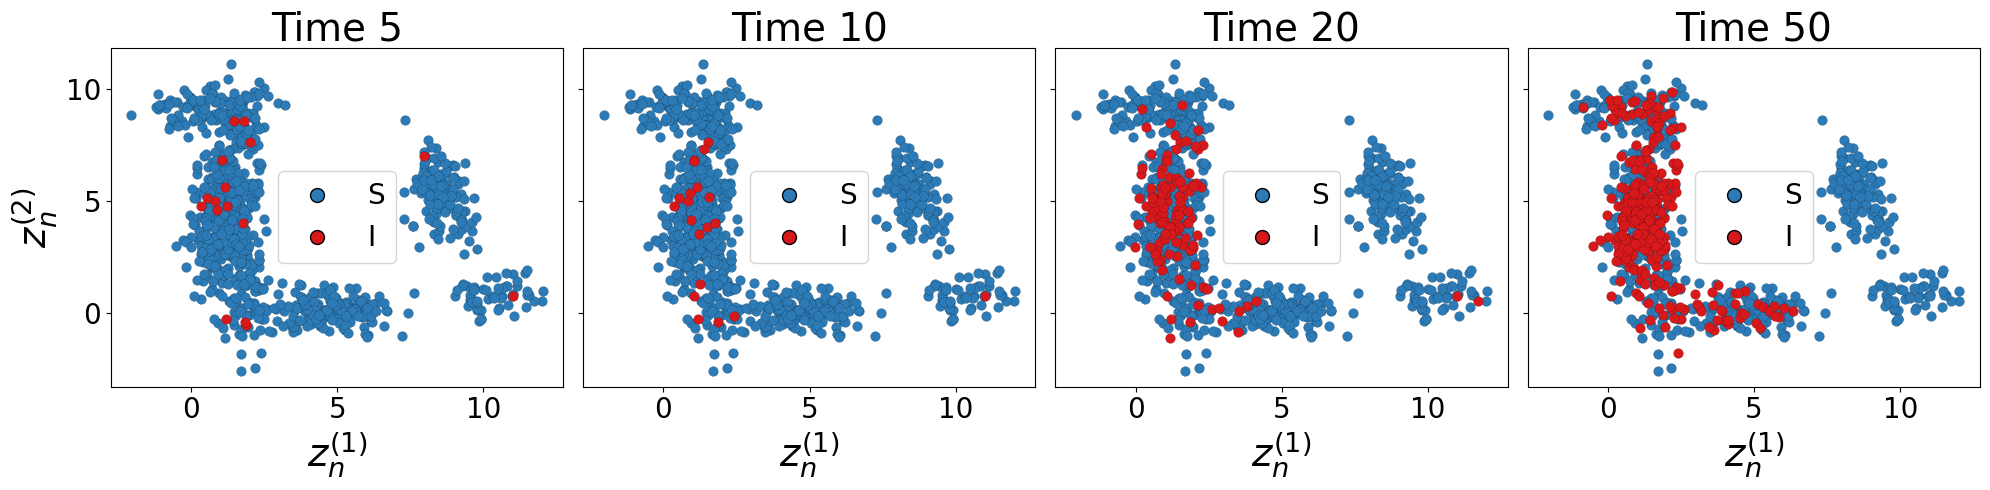

In [7]:
SIS = spatial_SIS(locations, covariates)

start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

fig, ax = plt.subplots(1, 4, figsize = (20, 5), sharex=True, sharey=True)

time_list = [5, 10, 20, 50]

ax[0].set_ylabel(r"$z_n^{(2)}$")

s_size = 50

for j in range(4):

	t = time_list[j]

	ax[j].set_title("Time "+str(t))

	infected = tf.where(X[t,:,1]==1)[:,0]

	loc_suscept = tf.gather(locations, tf.where(X[t,:,0]==1)[:,0], axis = 0)
	loc_infecte = tf.gather(locations, tf.where(X[t,:,1]==1)[:,0], axis = 0)

	ax[j].scatter(loc_suscept[:,0], loc_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	ax[j].scatter(loc_infecte[:,0], loc_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	
	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	]

	ax[j].legend(handles=legend_handles)

	ax[j].set_xlabel(r"$z_n^{(1)}$")

plt.subplots_adjust( wspace=0.4)
plt.tight_layout()

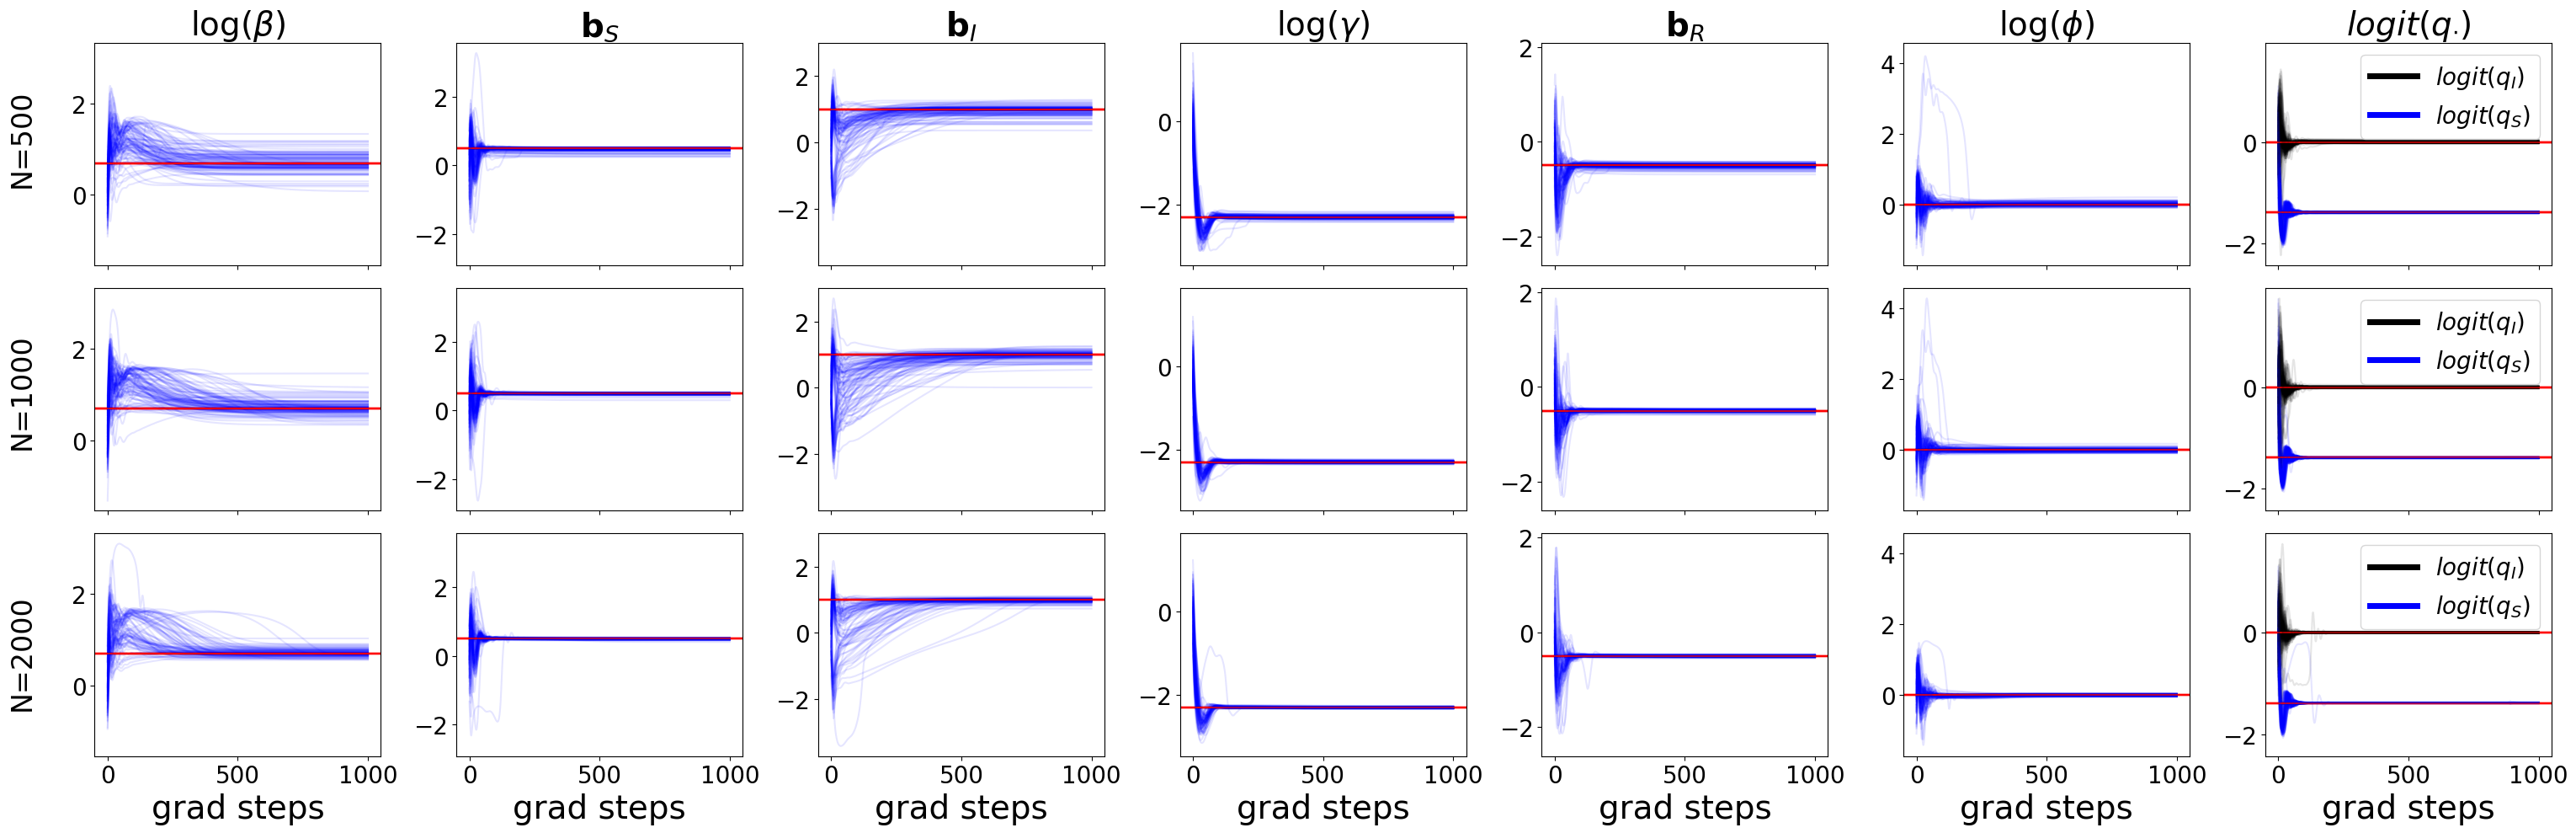

In [8]:
learning_parameters = {"log_beta":1, "b_S":1, "b_I":1, "log_gamma":1, "b_R":1, "log_phi":1, "logit_prob_testing":2} 


ylabel_dict = { "log_beta" : "$\\log(\\beta)$", 
		"b_S" : "$\mathbf{b}_{S}$", 
		"b_I": "$\mathbf{b}_{I}$", 
		"log_gamma": "$\\log(\\gamma)$", 
		"b_R": "$\mathbf{b}_{R}$",
		"log_phi":"$\\log(\\phi)$",
		"logit_prob_testing":"$logit(q_{\cdot})$",
		}

colors_list         = ["blue", "black", "yellow"]

N_list = [500, 1000, 2000]

fig, ax = plt.subplots(len(N_list), len(learning_parameters), figsize = (30, 10), sharex=True, sharey="col")

for n_index in range(len(N_list)):
	N = N_list[n_index]

	output_path = "Data/SpatialInference/Output/"+str(N)+"/"
	true_loss_file_name        = "spatial_inference_"+str(N)+"_true_loss.npy"
	optim_loss_file_name       = "spatial_inference_"+str(N)+"_optim_loss.npy"
	optim_parameters_file_name = "spatial_inference_"+str(N)+"_optim_parameters.npy"

	true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
	optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
	optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

	index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

	for i in range(n_covergage):

		if i in index:

			trial_index = np.nanargmin(optim_loss[i,:,-1])

			counter = -1
			for key in learning_parameters.keys():
				for j in range(learning_parameters[key]):

					ax[n_index, counter+1].plot(optim_parameters[key][i,trial_index,:, j], color = colors_list[j], alpha = 0.1)
					ax[n_index, counter+1].axhline(parameters[key][j].numpy(), color = "red", alpha = 0.1)

				if n_index == 0:
					ax[n_index, counter+1].set_title(ylabel_dict[key])	

				# if (counter+1) == len(learning_parameters.keys()):
				if n_index == 2:
					ax[n_index, counter+1].set_xlabel("grad steps")
				
				counter = counter +1

custom_lines = [
	plt.Line2D([0], [0], color='black', linestyle='-', linewidth=5, label=r'$logit(q_{I})$'),
	plt.Line2D([0], [0], color='blue', linestyle='-', linewidth=5, label=r'$logit(q_{S})$')
]

ax[0, 6].legend(handles=custom_lines, loc="upper right")
ax[1, 6].legend(handles=custom_lines, loc="upper right")
ax[2, 6].legend(handles=custom_lines, loc="upper right")

fig.text(
x=-0.02, y=0.22,  
s="N=2000",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

fig.text(
x=-0.02, y=0.53, 
s="N=1000",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

fig.text(
x=-0.02, y=0.83,  
s="N=500",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

plt.subplots_adjust( wspace=0.4)
plt.tight_layout()

In [9]:
table_dict = {}
counter = 0
for key in learning_parameters.keys():

	table_dict[key] = []

	for j in range(learning_parameters[key]):
		optim_param_list = []
		for n_index in range(len(N_list)):
			N = N_list[n_index]

			output_path = "Data/SpatialInference/Output/"+str(N)+"/"
			true_loss_file_name        = "spatial_inference_"+str(N)+"_true_loss.npy"
			optim_loss_file_name       = "spatial_inference_"+str(N)+"_optim_loss.npy"
			optim_parameters_file_name = "spatial_inference_"+str(N)+"_optim_parameters.npy"

			true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
			optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
			optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

			index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

			trial_index = np.nanargmin(optim_loss[index,...,-1], axis =1)
			to_append = np.stack([optim_parameters[key][trial,trial_index[trial],-1,j] for trial in index])
			# to_append = optim_parameters[key][2,:,-1,j]

			optim_param_list.append(tf.gather(to_append, tf.where(tf.math.is_nan(to_append)==False))[:,0])

		table_dict[key].append(optim_param_list)

	counter = counter +1

In [10]:
from tabulate import tabulate

# assign data
table = []

for key in learning_parameters.keys():
	for j in range(learning_parameters[key]):
		row = []
		row.append(ylabel_dict[key]+" = "+str(np.round(parameters[key][j].numpy(), 3)))
		for n_index in range(len(N_list)):

			row.append(str(np.round(np.nanmean(table_dict[key][j][n_index]), 3))+" ("+str(np.round(np.nanstd(table_dict[key][j][n_index]), 3))+")")
		
		table.append(row)
 
# create header
head = ["Parameter", "N=500", "N=1000", "N=2000"]
 
# display table
print(tabulate(table, headers=head, tablefmt="latex_raw"))

\begin{tabular}{llll}
\hline
 Parameter                   & N=500          & N=1000         & N=2000         \\
\hline
 $\log(\beta)$ = 0.693       & 0.709 (0.213)  & 0.713 (0.169)  & 0.717 (0.085)  \\
 $\mathbf{b}_{S}$ = 0.5      & 0.45 (0.06)    & 0.482 (0.031)  & 0.488 (0.022)  \\
 $\mathbf{b}_{I}$ = 1.0      & 0.954 (0.158)  & 0.971 (0.155)  & 0.977 (0.063)  \\
 $\log(\gamma)$ = -2.303     & -2.305 (0.043) & -2.295 (0.026) & -2.303 (0.016) \\
 $\mathbf{b}_{R}$ = -0.5     & -0.513 (0.049) & -0.501 (0.027) & -0.503 (0.018) \\
 $\log(\phi)$ = 0.0          & 0.014 (0.054)  & -0.003 (0.049) & -0.0 (0.026)   \\
 $logit(q_{\cdot})$ = -1.386 & -1.386 (0.01)  & -1.387 (0.007) & -1.386 (0.005) \\
 $logit(q_{\cdot})$ = 0.0    & 0.001 (0.018)  & 0.003 (0.013)  & 0.001 (0.007)  \\
\hline
\end{tabular}


# Graph model

In [11]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([2.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+1.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([-0.5], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([1], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32))}

T = 200
n_covergage = 100
n_gradient_steps = 1000
n_trial = 10

In [12]:
N = 1000
centroids  = np.load("Data/GraphInference/Input/centroids.npy")
city_index = np.load("Data/GraphInference/Input/city_index.npy")

index             = tf.convert_to_tensor(np.load("Data/GraphInference/Input/reshuffle.npy")[:N], dtype = tf.int32)
covariates_sample = tf.convert_to_tensor(np.load("Data/GraphInference/Input/covariates.npy"), dtype = tf.float32)

covariates  = tf.gather(covariates_sample, index, axis = 0)
communities = tf.gather(city_index, index, axis = 0)

2.7700765132904053


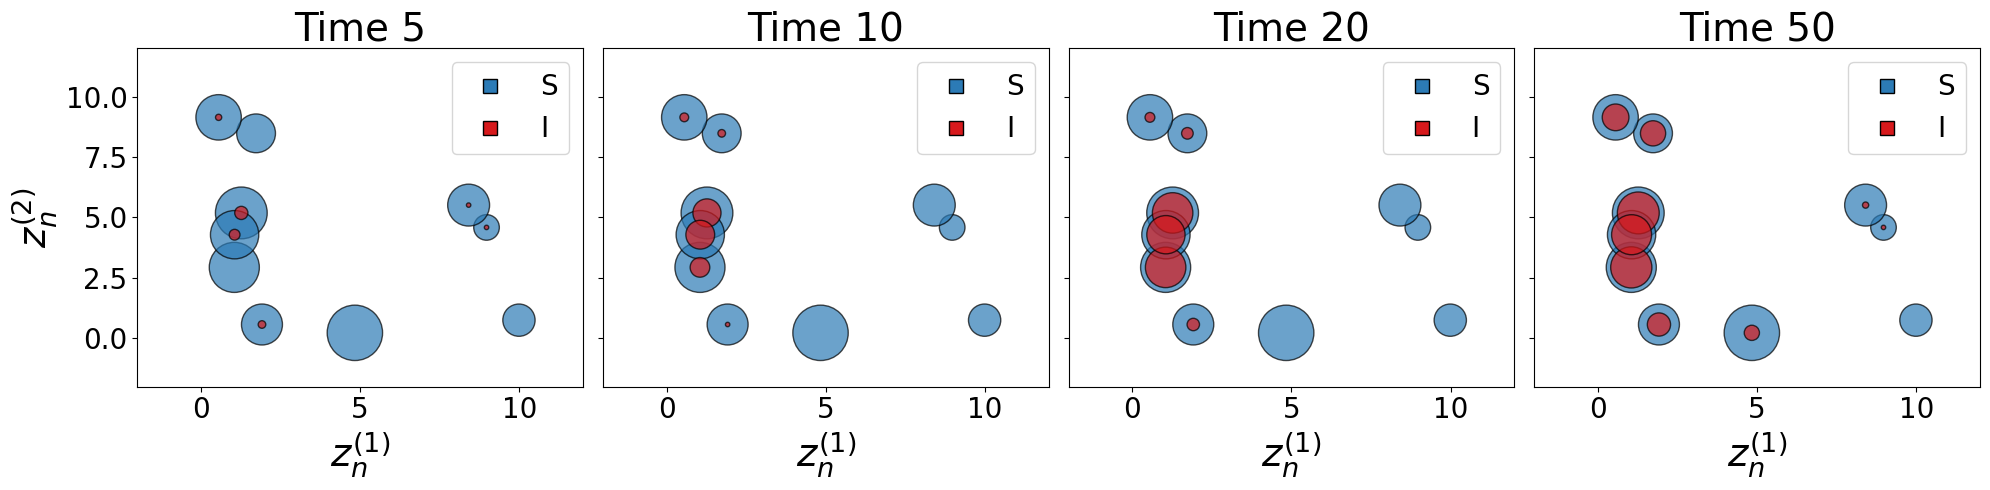

In [13]:
SIS = sbm_SIS(communities, centroids, covariates)

start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)
X, Y = X[:,0,...], Y[:,0,...]

fig, ax = plt.subplots(1, 4, figsize = (20, 5), sharex=True, sharey=True)

time_list = [5, 10, 20, 50]

ax[0].set_ylabel(r"$z_n^{(2)}$")

scaling_factor = 10

for j in range(4):

	t = time_list[j]
	ax[j].set_title("Time "+str(t))

	infected_per_community = tf.einsum("...nm,nc->...cm", X[t,...], SIS.communities)

	ax[j].scatter( centroids[:, 0], centroids[:, 1], color="#2c7bb6", s=scaling_factor*(infected_per_community[...,0] 
												+ infected_per_community[...,1]), edgecolors="black", alpha = 0.7 )
	ax[j].scatter( centroids[:, 0], centroids[:, 1], color="#d7191c", s=scaling_factor*(infected_per_community[...,1]), edgecolors="black", alpha = 0.7 )
	
	ax[j].set_xlim((-2, 12))
	ax[j].set_ylim((-2, 12))

	# Adding a legend with just the colors
	legend_colors = [
	("#2c7bb6", "S"),  
	("#d7191c", "I")
	]

	# Create legend handles
	handles = [
	plt.Line2D([0], [0], marker='s', color=color, markersize=10, markeredgecolor='black', linestyle='None', label=label)
	for color, label in legend_colors
	]

	# Add the legend
	ax[j].legend(handles=handles, loc='upper right')
	ax[j].set_xlabel(r"$z_n^{(1)}$")

plt.subplots_adjust( wspace=0.4)
plt.tight_layout()

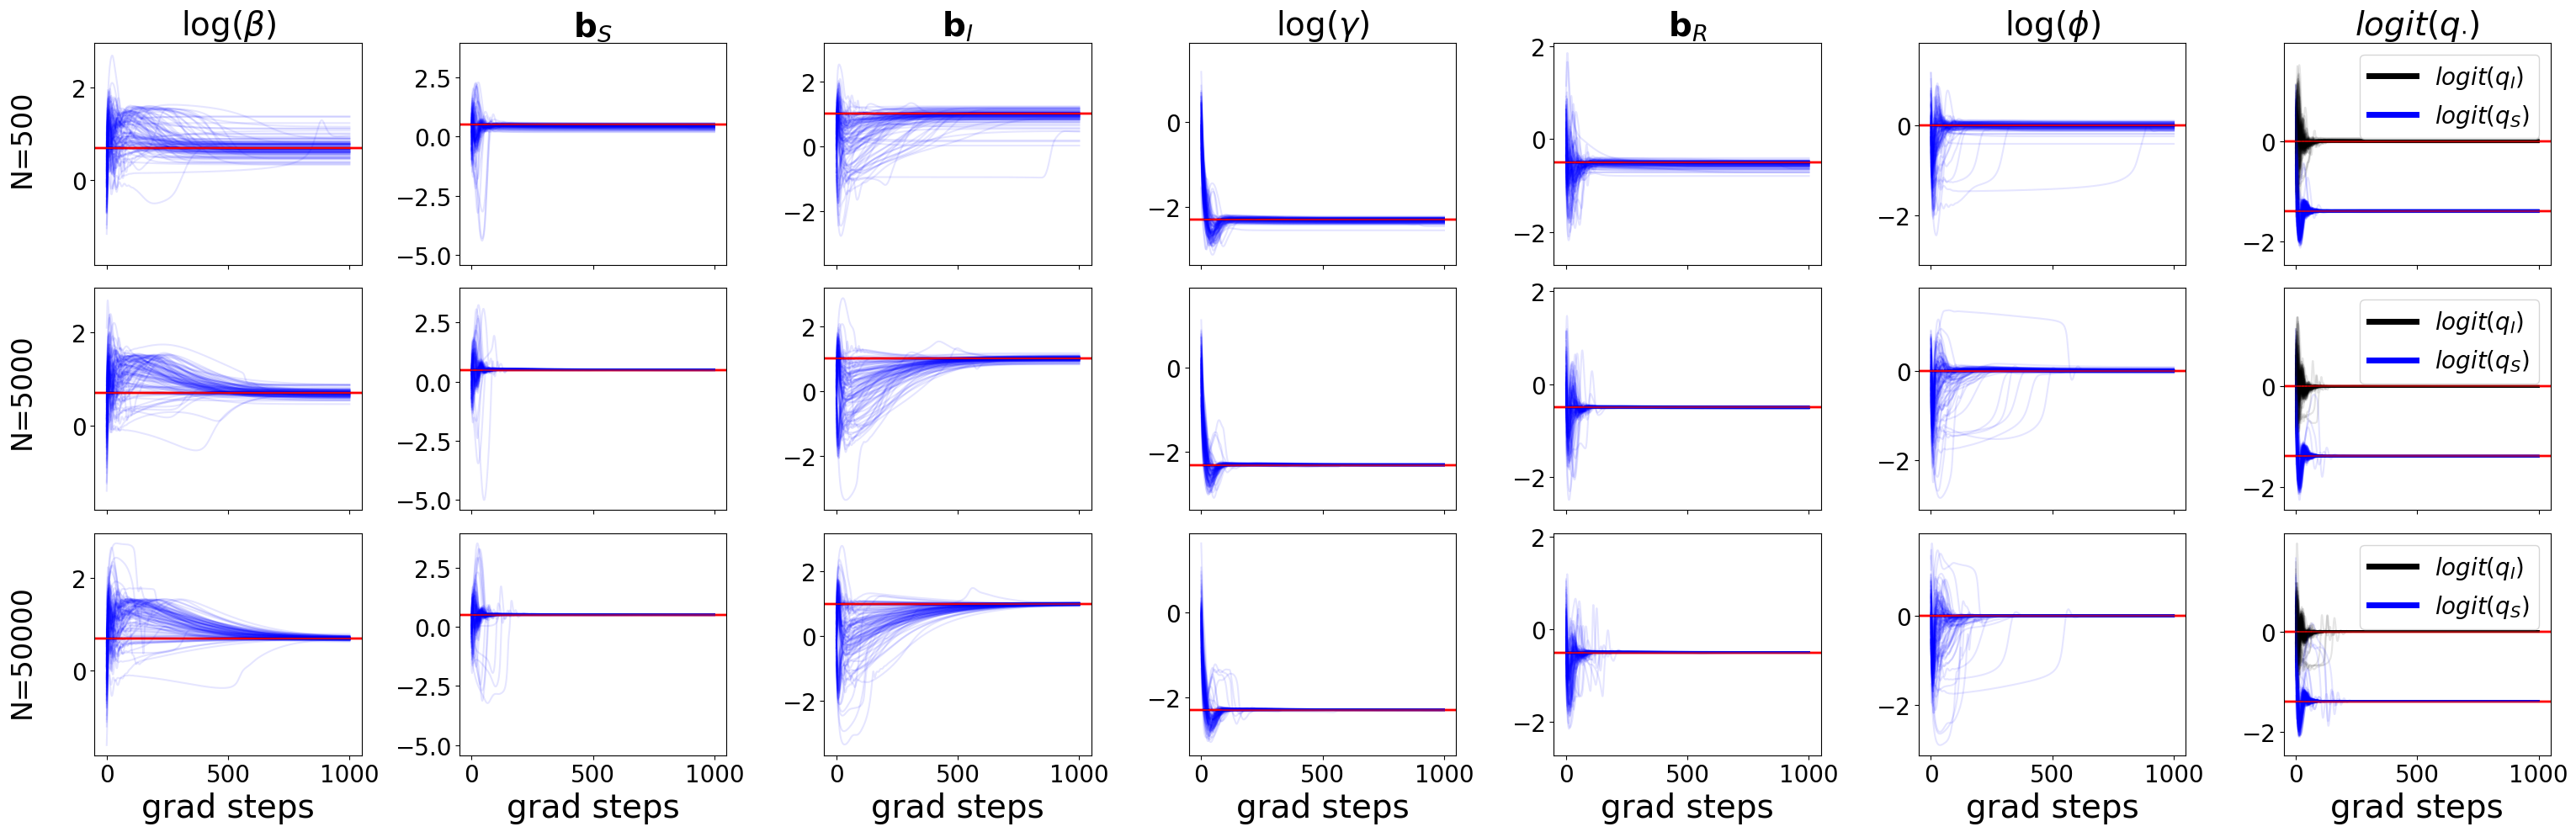

In [14]:
learning_parameters = {"log_beta":1, "b_S":1, "b_I":1, "log_gamma":1, "b_R":1, "log_phi":1, "logit_prob_testing":2} 


ylabel_dict = { "log_beta" : "$\\log(\\beta)$", 
		"b_S" : "$\mathbf{b}_{S}$", 
		"b_I": "$\mathbf{b}_{I}$", 
		"log_gamma": "$\\log(\\gamma)$", 
		"b_R": "$\mathbf{b}_{R}$",
		"log_phi":"$\\log(\\phi)$",
		"logit_prob_testing":"$logit(q_{\cdot})$",
		}

colors_list         = ["blue", "black", "yellow"]

N_list = [500, 5000, 50000]

fig, ax = plt.subplots(len(N_list),len(learning_parameters), figsize = (30, 10), sharex=True,  sharey="col")

for n_index in range(len(N_list)):
	N = N_list[n_index]

	# ax[0,n_index].set_title(r"$N=$"+str(N))

	output_path = "Data/GraphInference/Output/"+str(N)+"/"
	true_loss_file_name        = "graph_inference_"+str(N)+"_true_loss.npy"
	optim_loss_file_name       = "graph_inference_"+str(N)+"_optim_loss.npy"
	optim_parameters_file_name = "graph_inference_"+str(N)+"_optim_parameters.npy"

	true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
	optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
	optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

	index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

	for i in range(n_covergage):

		if i in index:

			trial_index = np.nanargmin(optim_loss[i,:,-1])	

			counter = -1
			for key in learning_parameters.keys():
				for j in range(learning_parameters[key]):

					ax[n_index, counter+1].plot(optim_parameters[key][i,trial_index,:, j], color = colors_list[j], alpha = 0.1)
					ax[n_index, counter+1].axhline(parameters[key][j].numpy(), color = "red", alpha = 0.1)

				if n_index == 0:
					ax[n_index, counter+1].set_title(ylabel_dict[key])	

				if n_index == 2: #(counter+1) == len(learning_parameters.keys()):
					ax[n_index, counter+1].set_xlabel("grad steps")

				counter = counter +1


custom_lines = [
	plt.Line2D([0], [0], color='black', linestyle='-', linewidth=5, label=r'$logit(q_{I})$'),
	plt.Line2D([0], [0], color='blue', linestyle='-', linewidth=5, label=r'$logit(q_{S})$')
]


ax[0, 6].legend(handles=custom_lines, loc="upper right")
ax[1, 6].legend(handles=custom_lines, loc="upper right")
ax[2, 6].legend(handles=custom_lines, loc="upper right")

fig.text(
x=-0.02, y=0.22,  
s="N=50000",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

fig.text(
x=-0.02, y=0.53, 
s="N=5000",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

fig.text(
x=-0.02, y=0.83,  
s="N=500",
fontsize=24,
va="center", ha="left",
rotation=90,
transform=fig.transFigure
)

plt.subplots_adjust( wspace=0.4)
plt.tight_layout()

In [15]:
table_dict = {}
counter = 0
for key in learning_parameters.keys():
	table_dict[key] = []
	for j in range(learning_parameters[key]):
		optim_param_list = []
		for n_index in range(len(N_list)):
			N = N_list[n_index]

			output_path = "Data/GraphInference/Output/"+str(N)+"/"
			true_loss_file_name        = "graph_inference_"+str(N)+"_true_loss.npy"
			optim_loss_file_name       = "graph_inference_"+str(N)+"_optim_loss.npy"
			optim_parameters_file_name = "graph_inference_"+str(N)+"_optim_parameters.npy"

			true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
			optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
			optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

			index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

			trial_index = np.nanargmin(optim_loss[index,...,-1], axis =1)
			to_append = np.stack([optim_parameters[key][trial,trial_index[trial],-1,j] for trial in index])
			# to_append = optim_parameters[key][2,:,-1,j]

			optim_param_list.append(tf.gather(to_append, tf.where(tf.math.is_nan(to_append)==False))[:,0])

		table_dict[key].append(optim_param_list)

	counter = counter +1

In [16]:
# assign data
table = []

for key in learning_parameters.keys():
	for j in range(learning_parameters[key]):
		row = []
		row.append(ylabel_dict[key]+" "+str(np.round(parameters[key][j].numpy(), 3)))
		for n_index in range(len(N_list)):

			row.append(str(np.round(np.nanmean(table_dict[key][j][n_index]), 4))+" ("+str(np.round(np.nanstd(table_dict[key][j][n_index]), 4))+")")
	
		table.append(row)
 
# create header
head = ["Parameter", "N=500", "N=5000", "N=50000"]
 
# display table
print(tabulate(table, headers=head, tablefmt="latex_raw"))

\begin{tabular}{llll}
\hline
 Parameter                 & N=500            & N=5000           & N=50000          \\
\hline
 $\log(\beta)$ 0.693       & 0.7176 (0.1953)  & 0.6888 (0.0772)  & 0.6983 (0.0302)  \\
 $\mathbf{b}_{S}$ 0.5      & 0.4211 (0.0794)  & 0.496 (0.0097)   & 0.4997 (0.0031)  \\
 $\mathbf{b}_{I}$ 1.0      & 0.9137 (0.204)   & 0.9996 (0.0622)  & 0.9951 (0.0249)  \\
 $\log(\gamma)$ -2.303     & -2.3211 (0.0517) & -2.3039 (0.0107) & -2.3027 (0.0031) \\
 $\mathbf{b}_{R}$ -0.5     & -0.545 (0.0676)  & -0.5022 (0.0111) & -0.4998 (0.0037) \\
 $\log(\phi)$ 0.0          & -0.019 (0.0731)  & 0.0014 (0.0238)  & -0.0008 (0.0068) \\
 $logit(q_{\cdot})$ -1.386 & -1.388 (0.0112)  & -1.3865 (0.0037) & -1.3863 (0.0013) \\
 $logit(q_{\cdot})$ 0.0    & 0.0074 (0.0155)  & 0.0003 (0.0041)  & 0.0001 (0.0012)  \\
\hline
\end{tabular}


# FM data

Unzip the folder

In [21]:
import pandas as pd
import geopandas as gp

In [17]:
learning_parameters = {
			"log_tau":1,
			"log_beta":1, "b_S":2, "b_I":2, "log_phi":1,	
			"log_gamma":1,
			"log_rho":1, "log_psi":1,
			"log_epsilon":1,
			"logit_prob_I_testing":1}
	

ylabel_dict = {#"logit_prior_infection": r"$\text{logit}(\pi_{n,0})$", 
		"log_tau": r"$\log(\tau)$", 
		"log_beta":r"$\log(\beta)$", "b_S":r"$\mathbf{b}_S$", "b_I":r"$\mathbf{b}_I$", "log_phi":r"$\log(\phi)$", 
		"log_gamma":r"$\log(\gamma)$", "log_psi":r"$\log(\psi)$", "log_rho":r"$\log(\rho)$","log_epsilon":r"$\log(\epsilon)$",
		"logit_prob_I_testing":r"$q_I$"}

list_best_param = []
list_best_loss = []

best_initial = []

for test in range(10):
	output_path = "Data/FM/Output_"+str(test)+"/"
	loss_file_name       = "FM_loss.npy"

	loss       = np.load(output_path+loss_file_name,       allow_pickle=False)
	best_index = np.argmin( np.where(np.isnan(loss[:,-1]), 100, loss[:,-1]))

	list_best_loss.append(loss[best_index,-1])

	dict_best_param = {}

	for i in range(int(len(learning_parameters.keys())/2)):
		for j in range(2):

			key = list(learning_parameters.keys())[2*i+j]

			optim_parameters_file_name = "FM_parameters_"+key+".npy"
			optim_parameters = np.load(output_path+optim_parameters_file_name)

			dict_best_param[key] = optim_parameters[best_index,-1,:]

	list_best_param.append(dict_best_param)



In [18]:
best_optim = np.argmin(np.stack(list_best_loss))

best_parameters = list_best_param[best_optim]

In [19]:
tf.sigmoid(best_parameters["logit_prob_I_testing"])

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.66661272])>

In [20]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [21]:
local_autorities_covariates  = tf.convert_to_tensor(np.load("Data/FM/local_autorities_covariates.npy"), dtype = tf.float32)
farms_covariates = tf.convert_to_tensor(np.load("Data/FM/farms_covariates.npy"), dtype = tf.float32)
Y = tf.convert_to_tensor(np.load("Data/FM/cut_Y_FM.npy"), dtype = tf.float32)

communities = farms_covariates[:,-1:]
farms_covariates = farms_covariates[:,:2]

In [23]:
import time

parameters = {}
for key in best_parameters.keys():
	parameters[key] = tf.convert_to_tensor(best_parameters[key], dtype = tf.float32) 

SIR = FM_SIR(local_autorities_covariates, communities, farms_covariates)

In [24]:
Y = tf.convert_to_tensor(np.load("Data/FM/cut_Y_FM.npy"), dtype = tf.float32)
Y_list_stack = np.load("Data/FM/Y_FM_list_stack.npy")

Pi, Mu, Log_likelihood = CAL(SIR, parameters, Y)

Text(0, 0.5, 'notified')

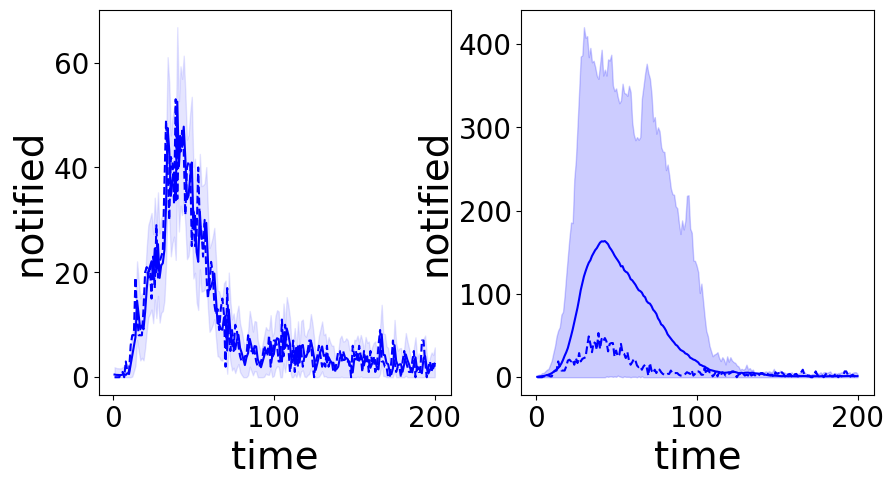

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

time = np.linspace(1, 200, 200)
ax[1].plot(time, np.mean(Y_list_stack, axis = 0), color = "blue", )
ax[1].fill_between(time, np.quantile(Y_list_stack, (0.025, 0.975), axis = 0)[0,:], np.quantile(Y_list_stack, (0.05, 0.95), axis = 0)[1,:], color = "blue", alpha = 0.2)
ax[1].plot(time, tf.reduce_sum(Y, axis = 1)[:200, 2], color = "blue", linestyle='dashed')
ax[1].set_xlabel("time")
ax[1].set_ylabel("notified")

ax[0].plot(time, tf.reduce_sum(Y, axis = 1)[:200,2], color = "blue", linestyle='dashed')
ax[0].plot(time, tf.reduce_sum(Mu, axis = 1)[:200,2], color = "blue", )

lower = tf.reduce_sum(Mu, axis = 1)[:200,2] - 1.96*tf.math.sqrt(tf.reduce_sum(Mu*(1-Mu), axis = 1))[:200,2] 
lower = tf.reduce_max(tf.stack((lower, tf.zeros(tf.shape(lower))), axis = -1), axis = -1)
upper = tf.reduce_sum(Mu, axis = 1)[:200,2] + 1.96*tf.math.sqrt(tf.reduce_sum(Mu*(1-Mu), axis = 1))[:200,2]
ax[0].fill_between(time, lower, upper, color = "blue", alpha=0.1)
ax[0].set_xlabel("time")
ax[0].set_ylabel("notified")

In [26]:
import seaborn as sns

def f(parameters, x, y):

    return tf.math.exp(x*parameters["b_S"][0] + y*parameters["b_S"][1] )

def h(parameters, x, y):
    
    return tf.math.exp(x*parameters["b_I"][0] + y*parameters["b_I"][1] )

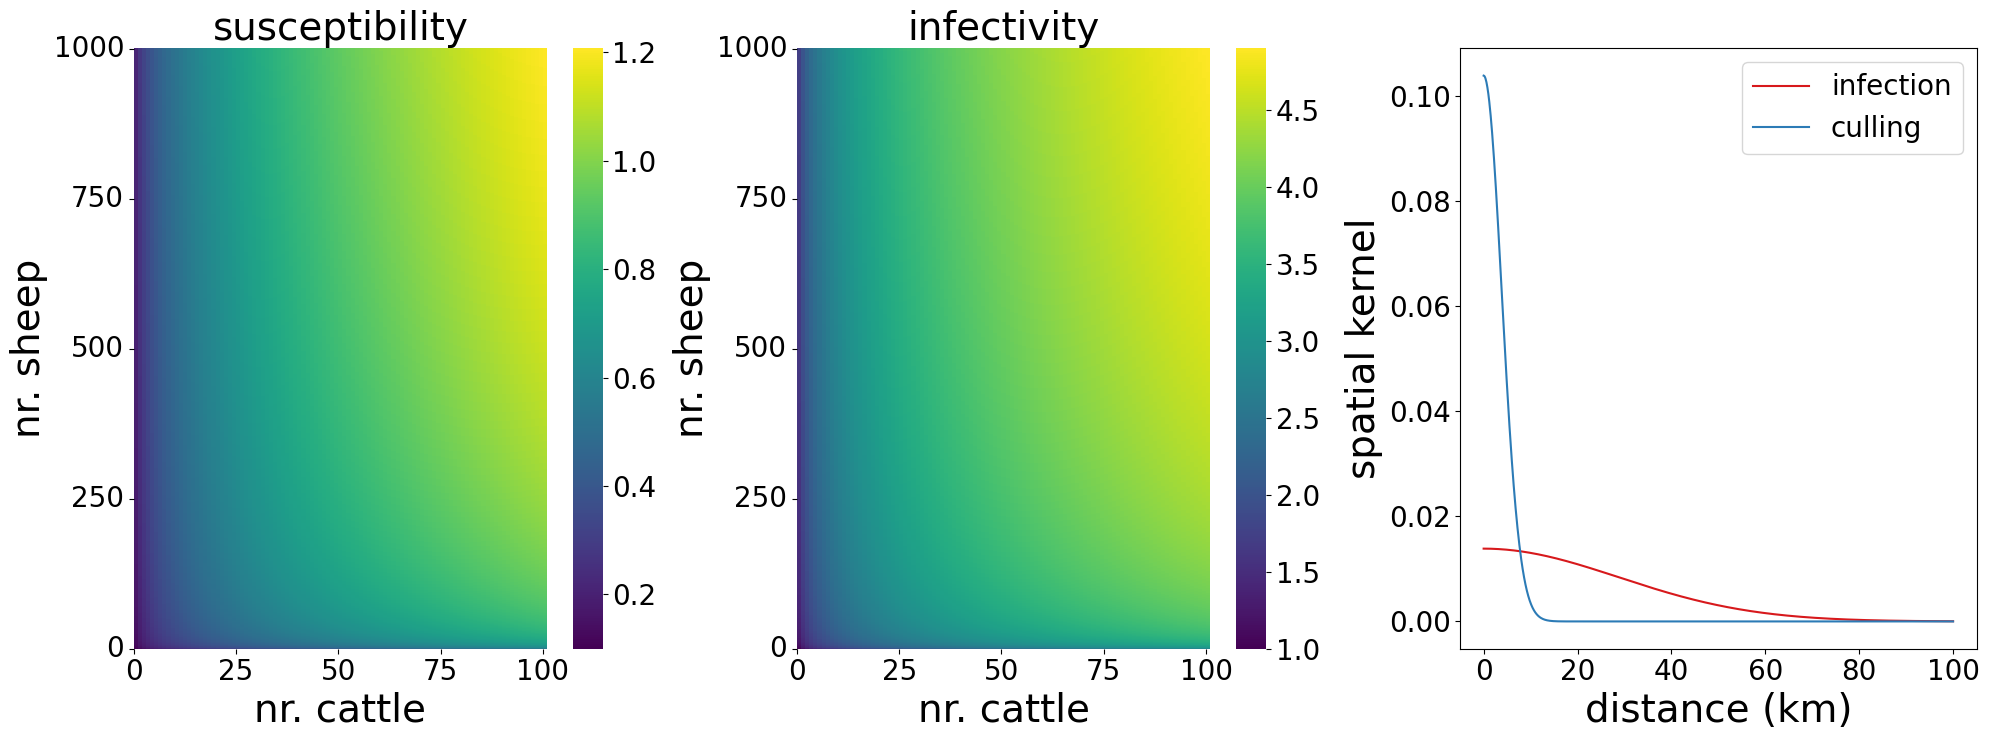

In [27]:
x = np.linspace(0, 100, 101)
y = np.linspace(0, 1000, 1001)
X, Y = np.meshgrid(np.log(1+x), np.log(1+y))
Z1 = f(parameters, X, Y)/10
Z2 = h(parameters, X, Y)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7.5))

sns.heatmap(Z1, ax=ax1, cmap='viridis') #, origin = "lower")
ax1.set_title('susceptibility')
ax1.set_xlabel('nr. cattle')  
ax1.set_ylabel('nr. sheep')  

# Set the x and y axis ticks to match x and y values
ax1.set_xticks(np.linspace(0, len(x)-1, num=5))  # 5 evenly spaced ticks
ax1.set_xticklabels(np.linspace(x.min(), x.max(), num=5).astype(int), rotation=0)
ax1.set_yticks(np.linspace(0, len(y)-1, num=5)[::-1])  # 5 evenly spaced ticks
ax1.set_yticklabels(np.linspace(y.min(), y.max(), num=5)[::-1].astype(int))

sns.heatmap(Z2, ax=ax2, cmap='viridis') #, origin = "lower")
ax2.set_title('infectivity')
ax2.set_xlabel('nr. cattle')  
ax2.set_ylabel('nr. sheep')  

# Set the x and y axis ticks to match x and y values
ax2.set_xticks(np.linspace(0, len(x)-1, num=5))  # 5 evenly spaced ticks
ax2.set_xticklabels(np.linspace(x.min(), x.max(), num=5).astype(int), rotation=0)
ax2.set_yticks(np.linspace(0, len(y)-1, num=5))  # 5 evenly spaced ticks
ax2.set_yticklabels(np.linspace(y.min(), y.max(), num=5).astype(int))

ax1.invert_yaxis()
ax2.invert_yaxis()


ax3.plot(np.linspace(0, 100, 1000), tfp.distributions.Normal(loc = 0, scale = tf.math.exp(parameters["log_phi"])).prob(np.linspace(0, 100, 1000)), color = "#d7191c", label = "infection")
ax3.set_xlabel("distance (km)")
ax3.set_ylabel("spatial kernel")
fig.tight_layout()

ax3.plot(np.linspace(0, 100, 1000), tfp.distributions.Normal(loc = 0, scale = tf.math.exp(parameters["log_psi"])).prob(np.linspace(0, 100, 1000)), color = "#2c7bb6", label = "culling")
ax3.set_xlabel("distance (km)")
ax3.set_ylabel("spatial kernel")
ax3.legend()


fig.tight_layout()

The exact location of the farms cannot be disclosed. As an alternative we show the aggregated version.

In [32]:
import pandas as pd
import geopandas as gp

geo_counties_valid = gp.read_file("Data/FM/geo_counties_valid.geojson", driver="GeoJSON")



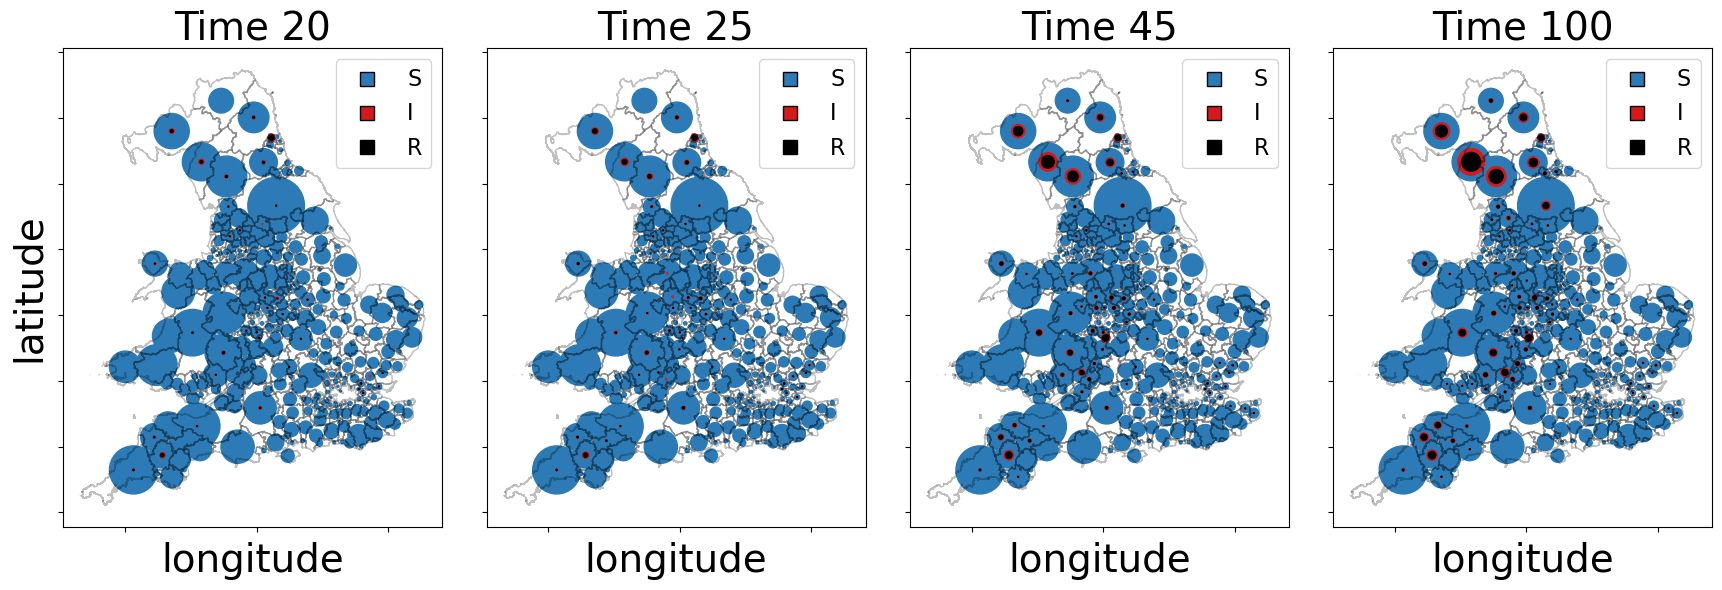

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), dpi=100)

time_steps = [20, 25, 45, 100]

for i in range(4):

	t = time_steps[i]

	if i==0:
		ax[i].set_ylabel('latitude')

	ax[i].set_xlabel('longitude')

	ax[i].set_xticklabels([])
	ax[i].set_yticklabels([])
	
	ax[i].set_title("Time "+str(t))

	Pi_loc_aut = tf.einsum("tfs,fc->tcs", tf.one_hot(tf.math.argmax(Pi, axis = -1), 3), tf.one_hot(tf.cast(communities[:,0], tf.int32), 289))

	ax[i].scatter( 1000*local_autorities_covariates[:,0], 1000*local_autorities_covariates[:,1], s = 0.2*(Pi_loc_aut[t,:,0] + Pi_loc_aut[t,:,1] + Pi_loc_aut[t,:,2]), color="#2c7bb6", edgecolors="#2c7bb6", alpha = 1 )
	ax[i].scatter( 1000*local_autorities_covariates[:,0], 1000*local_autorities_covariates[:,1], s = 0.8*(Pi_loc_aut[t,:,1] + Pi_loc_aut[t,:,2]                    ), color="#d7191c", edgecolors="#d7191c", alpha = 1 )
	ax[i].scatter( 1000*local_autorities_covariates[:,0], 1000*local_autorities_covariates[:,1], s = 0.4*(Pi_loc_aut[t,:,2]                                        ), color="black",   edgecolors="black", alpha = 1 )
	geo_counties_valid.plot(ax = ax[i], color = "none", edgecolor='black', alpha = 0.25)

	legend_handles = [
	plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="black", markeredgecolor='black', markersize=10, label="R"),
	]

	ax[i].legend(handles=legend_handles, fontsize=16)

plt.subplots_adjust( wspace=-0.75)
plt.tight_layout()